<a href="https://colab.research.google.com/github/yecatstevir/teambrainiac/blob/main/source/SingleSubjectSVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Whole Brain Support Vector Machine Training
- Go to 'Runtime' in Colab browser bar, select 'Change Runtime Type', select 'High-RAM' from 'Runtime Shape'. 
- load local pickle file containing all masked, normalized Whole Brain subject data in numpy matrix format
- SVM training per subject

### Mount Google Drive and clone repository
- open to source directory

In [31]:
from google.colab import drive
drive.mount('/content/gdrive')#, force_remount = True)

Mounted at /content/gdrive


In [32]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [33]:
# Clone the entire repo.
!git clone -l -s https://github.com/yecatstevir/teambrainiac.git
# Change directory into cloned repo
%cd teambrainiac/source
!ls


Cloning into 'teambrainiac'...
remote: Enumerating objects: 1323, done.
remote: Counting objects: 100% (1323/1323), done.
remote: Compressing objects: 100% (1036/1036), done.
remote: Total 1323 (delta 849), reused 536 (delta 271), pack-reused 0
Receiving objects: 100% (1323/1323), 83.71 MiB | 25.71 MiB/s, done.
Resolving deltas: 100% (849/849), done.
/content/teambrainiac/source/teambrainiac/source
access_data.py			  __init__.py
AccuracyMeasures.ipynb		  models
data				  process.py
DataExploration_SingleSubj.ipynb  SingleSubjectSVM.ipynb
DataExplorationVisuals.ipynb	  streamlit
DL				  SubjectVisualization_Models_ZNORM.ipynb
group_svm			  TestMask.ipynb
helper				  utils.py
images				  VisualizationPlayground.ipynb


### Load path_config.py 
- we are already in source so we can just load this file without changing directory

In [34]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving path_config.py to path_config.py
User uploaded file "path_config.py" with length 228 bytes


### Import libraries


In [35]:


# Import libraries
!pip install boto3 nilearn nibabel #for saving data and image visualizations
import pickle
#sklearn packages needed
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, auc, recall_score, precision_score,roc_curve,f1_score
#important utility functions for loading,masking,saving data
#from utils import *
from access_data import *
from process import *
#normal python packages we use
import numpy as np
import pandas as pd
from scipy import signal
from nilearn.signal import clean

### Get paths to subject data and grab labels for SVM

In [36]:

## load and open the pickle file that contains paths to all data.
path = "data/data_path_dictionary.pkl"
data_path_dict = open_pickle(path)

##get mask_dictionary


###Functions to get information about data to run our SVM

In [37]:
def get_subj_information(data_path_dict):
  """
    Function to get subject information.
    data_path_dict  : dictionary containing paths to all data stored on AWS
    returns:  subject_ids(list of subjects to run),subj_paths(paths to subject raw data)
  """
  subject_ids = data_path_dict['subject_ID'] #subject_ids
  subj_paths = data_path_dict['subject_data'] #subject_paths
  return subject_ids,subj_paths

def get_labels(data_path_dict):
  """
    Function to get the labels for our data.
    data_path_dict  : dictionary containing paths to all data stored on AWS
    returns: mask_labels_indices(timepoints we want masked out),binary_labels(labels for our for our two brain states)
             and label_type
  """
  
  label_data_path = data_path_dict['labels'][0] #get labels
  label_type = 'rt_labels' #tell the function what labels we want
  mask_labels_indices, binary_labels = labels_mask_binary(label_data_path, label_type) #grab indices and labels
  return mask_labels_indices, binary_labels,label_type

def get_mask_data(data_path_dict,mask_ind):
  """
    Function to return the mask of what brain voxels we want to include in analysis
    Params:
      data_path_dict  : dictionary: containing paths to data
      mask_ind: int: index of where the path to the masks are 0: full brain mask plus masks that subtract region
                1: Regions of interest(ROIs) mask out full brain except structure we care about
    returns: dictionary: contains mask data
    
  """
  mask_data_filepath = data_path_dict['mask_data'][mask_ind] #path to masked data     
  mask_type_dict = access_load_data(mask_data_filepath, True) #get the mask data dictionary
  
  return mask_type_dict

In [38]:
def make_mask(np_array_mask):
  """
    Function to create boolean mask to mask out voxels we don't want
    Params:
      mask_type: string: which mask to grab to get boolean array
    returns: boolean array of voxels to include
  """
  #np_array_mask = mask_data[mask_type] #get the mask array
  #create a 1-D array for the mask. Important to use Fourier Transformation as we are working in brain space!
  mask = np.ma.make_mask(np_array_mask).reshape(79*95*79,order='F')
  return mask

## Set up SVM Model

In [39]:
def mask_data(data,mask,mask_labels_indices):
  """
    Function to mask user data to mask out voxels we don't want
    Params:
      data: dictionary: subject data dictionary contain 4 runs of unmasked data
      mask: nd.array: 1-d array boolean values used to only include voxels we want.
      mask_labels_indices: indices of rows we want in to include in our model
    returns: dictionary: includes 4 runs of masked data
  """
  user_data_dict = {} #create empty dict
  arr = []
  for i in tqdm.tqdm(range(4)):
      user_key = 'run_0' + str(i+1) + '_vec'
      array = data[user_key]
      array_masked = array[:, mask]
      array_masked = array_masked[mask_labels_indices]  
      arr.append(array_masked)
  user_data_dict['data'] = arr
  return user_data_dict

In [48]:
def scale_data_single_subj(sub_data,train_runs,test_runs,norm='none'):
  """
    Function to scale data.
    Params:
      sub_data     : (1 subject data, keys as subject ID for frmi data or labels)
      sub_id       : subject id  of subject we are normalizing for
      runs_test    : tuple, (which run are we using for the test data)
      norm         : list, ("RUNS": normalizing separately on each run;
                              "SUBJECT": Normalizing separately by each subject)
    returns      : dictionary of nd.arrays, Concatenated X data of (time points, x*y*z) x = 79, y = 95, z = 75
                    and Concatenated y labels of (time points,)
    """
  ##run standardization
  ##initialize empty dictionary
  normalized_runs = {}
  for run in runs_list:
    run_name = user_key = 'run_0' + str(run) 
    run_data = sub_data['data'][run-1]
    if norm=='none':
      normalized_runs[run_name] = clean(run_data,detrend=True,standardize=False,filter=False,standardize_confounds=False)
    else:
      normalized_runs[run_name] = clean(run_data,detrend=True,standardize=norm,filter=False,standardize_confounds=False)
  return normalized_runs

In [92]:
def get_accuracy_scores(clf,data,X_train,y_train,runs_test,y_labels):
  """
    Function to get accuracy scores for subject models.
    Params:
      model_dict: contains subject model and training/test/val/data
      subj: subject name 
      normalization_type: options: 'PSC','ZNORM','none' what type of normalization
    returns: subj_list, list of subject metrics
  """
  accuracy_list = []
  df_columns = ['train_acc']
  y_predicts = clf.predict(X_train)
  accuracy_list.append(accuracy_score(y_train,y_predicts))
  for run in runs_test:
    y_predicts = clf.predict(data[run])
    df_columns.append(run + '_acc')
    accuracy_list.append(accuracy_score(y_labels,y_predicts))
    df_columns.append(run+'_f1_score')
    accuracy_list.append(f1_score(y_labels,y_predicts))
    
    
  return accuracy_list,df_columns

In [50]:
def get_predicts(clf,data,runs_test):
  """
    Function to get accuracy scores for subject models.
    Params:
      model_dict: contains subject model and training/test/val/data
      subj: subject name 
    returns: y_val_predicts(if validation run),y_test_predicts
  """
  predictions_dict = {}
  for runs in runs_test:
    predictions_dict[runs] = {}
    predictions_dict[runs]['predicts'] = clf.predict(data[runs])
    predictions_dict[runs]['proba'] = clf.proba(data[runs])
    predictions_dict[runs]['decision_function'] = clf.decision_function[runs]

                                                  
  return predictions_dict

In [55]:
def run_single_subject_svm(data,runs_train,train_labels,svc_kernel='rbf',svc_c=1,do_cv=False,params={}):
  """
    Function to run cross-validation or single subject SVM
    Params:
      tuple: contains
        X_train      : 2-d array of training data
        y_train   : sub_labels to indicate which row of the sub_data belongs to increase/decrease state
        svc_kernel : kernel for svc
        svc_c: c value for svc
      optionals:
        do_cv: boolean: to decide if cross-validation gridsearch is requested: default=False
        params: dictionary: dictionary containing params to grid search: default=empty dictionary
    returns      : subject individual model
  """ 
  #run cv if do_cv = True, else run individual model SVM
  X_train = []
  y_train = []
  if len(runs_train)>1:
        for run in runs_train:
          X_train.append(data[run])
          y_train.append(train_labels)    
        X_train = np.concatenate(np.array(X_train))
        y_train = np.concatenate(np.array(y_train))
  else:
    X_train = data[runs_train[0]]
    y_train = train_labels
  if do_cv:
    #cv_params = {'C':[0.7, 1, 5, 10],'kernel':['linear', 'rbf']}
    svc = SVC()
    clf = GridSearchCV(svc, params)
    clf.fit(X_train,y_train)
    return clf
  else:
    clf = SVC(C=svc_c,kernel=svc_kernel,probability=True)
    clf.fit(X_train,y_train)
  return clf,X_train,y_train

In [44]:

def run_subject_model(data_path_dict,path,file_name,runs_train,runs_test,mask_list,mask_ind_list,norm_type='NONORM'):
  """
    Function loops over subjects to grap data,scale,data,and run the SVM.
    data_path_dict  : dictionary containing paths to all data stored on AWS
    path : path to save pickle files. NOTE: If run on all subjects, this will take up about 20 GB
    file_name : name of file to prepend to subject id
    runs_train: what runs do we want to train on
    runs_test: what runs do we want to test on
    mask_type: which type of brain mask do we want to apply
    mask_ind: to distinguish between ROI regions of masking(1) and full brain(or full_brain minus ROIs)(0)
    do_psc: do we want to apply Percent Signal Change normalization. Default = True,
    norm: Takes three parameters: none(no normalization will be applied),"SUBJECT"(apply normalization per subject)
          "RUNS"(apply normalization per run separately)
  """
  model_dict = {}
  #get subject information
  subject_ids,subj_paths = get_subj_information(data_path_dict)
  
  #get mask labels to only retrieve time series we care about
  mask_labels_indices,binary_labels,label_type = get_labels(data_path_dict)
  #get mask data
  
  #loop over subjects
  for idx in range(len(subject_ids)):
    sub_id = subject_ids[idx] #get subject id
    subj_path = subj_paths[idx] #get subject path
    #get subject raw data
    #call function to load data and return a dictionary. We are loading .mat files so need to set second param to True
    sub_data_unmasked = access_load_data(mat_path,True)
    #loop over masks indices to reach masks or rois
    for mind in mask_ind_list:   
      mask_data_dict = get_mask_data(data_path_dict,mask_ind_list[mind])
      #loop over masks we want to run
      for mask_type in mask_list:
       
        mask = create_mask(mask_type)
        #mask_data
        sub_data_masked = mask_data(sub_data_unmasked,mask_labels_indices,binary_labels)
        sub_data = sub_data_masked[sub_id]
        #normalize data if indicated and return train data/labels,val data/labels, test data/labels
        normalized_runs = scale_data_single_subj(sub_data,binary_labels,runs_list,norm_type=norm_type)
        #run svm, add clf to dictionary
        clf = run_single_subject_svm(train_data,svc_kernel,svc_c,do_cv=False,params={})
        #run get predicts to get predictions and add to subject_model_dictionary
        final_model_dict = get_predicts(model_dict['model'],val_test_data_labels)
        model_dict[sub_id]['y_test_predicts'] = y_test_predicts
        model_dict[sub_id]['y_test_proba'] = y_test_proba
        model_dict[sub_id]['y_test_dec_func'] = y_test_dec_func
    if len(y_val_predicts)>0:
      model_dict[sub_id]['y_val_predicts'] = y_val_predicts
      model_dict[sub_id]['y_val_proba'] = y_val_proba
      model_dict[sub_id]['y_val_dec_func'] = y_val_dec_func
    destination_path = f'{path}{file_name}{sub_id}.pkl'     
    single_model_path[sub_id] = destination_path
    # filehandler = open(destination_path,"wb") #comment out this
    # pickle.dump(model_dict,filehandler) #comment out this
    # filehandler.close() #comment out this
    object_name = destination_path
    s3_upload(model_dict,object_name,"pickle")
  object_name = f'{path}{mask_type}_data_path_dict.pkl'
  s3_upload(single_model_path,object_name,"pickle")
  # filehandler = open(object_name,"wb") #comment out this
  # pickle.dump(single_model_path,filehandler) #comment out this
  # filehandler.close() #comment out this
  return model_dict

In [ ]:

###data exploration for different normalization strategies
input_data_path = f'/content/drive/My Drive/data/masked_unnorm_data.pkl' ##once data is masked, we can save it locally
##what runs do you want to normalize on
runs_train=['run_02'] #runs we want to train on
runs_test=['run_03','run_04'] #runs we want to test on
runs_list=[2,3,4]
##for fMRI, we always want to detrend the data
norm_list = ['psc','zscore','none'] #list of normalization strategies you want to test
svc_kernel='rbf' #specify kernel 
svc_c = 1 #specify c parameter
save_data_path = f'/content/drive/My Drive/data/{svc_kernel}_exploration/'
sub_acc = [] #initialize empty list to store accuracy scores
save_sub_dict = {}
csv_dict = {}
path_data_file = f'{save_data_path}_norms_paths.pkl'
subject_data_file = f'{save_data_path}_norm_data.pkl'
for norm_type in norm_list: #loop  over norm_type
norm_type_name = f'detrend_{norm_type}'
file_name = f'{norm_type_name}.pkl' #name of file to save data to
mask_list = ['mask']
mask_indices = [0]
#get subject information
subjs_id, subjs_paths = get_subj_information(data_path_dict)
#get mask labels to only retrieve time series we care about
mask_labels_indices,binary_labels,label_type = get_labels(data_path_dict)
model_dict = {}
for idx in range(len(subjs_id)):
  subj_id = subjs_id[idx]
  subj_path = subjs_paths[idx]
  subj_data = access_load_data(data_path_dict,True)
  for midx in mask_indices:
    mask_dict = get_mask_data(data_path_dict,midx)
    for mask_type in mask_list:
      mask = make_mask(mask_dict[mask_type])
      masked_data = mask_data(subj_data,mask,mask_labels_indices)
      for norm_type in norm_list:
        scaled_data = scale_data_single_subj(masked_data,runs_train,runs_test,norm=norm_type)
        clf,X_train,y_train = run_single_subject_svm(scaled_data,runs_train,binary_labels,svc_kernel,svc_c)
        if
        model_dict[subj_id]['model'] = clf
        model_dict[subj_id]['X_train'] = X_train
        model_dict[subj_id]['y_train'] = y_train
          

#get mask data
def run_subject_model(subj_data,norm_type,svc_kernel,svc_c,save_data_path,train_runs,test_runs,mask_list):


 
  for sub_id in subject_ids:
    sub_data = subjects_masked_data[sub_id]
    sub_data_norm = scale_data_single_subj(sub_data,run_list,norm=norm_list[0])
    X_train = sub_data_norm[runs_train[0]]
    X_val = sub_data_norm[runs_test[0]]
    X_test = sub_data_norm[runs_test[1]]
    clf = run_single_subject_svm(X_train,binary_labels,svc_kernel,svc_c,do_cv=False,params={})
    acc = get_accuracy_scores(clf,X_train,X_val,X_test)
    sub_acc.append(acc)
    if sub_id in subject_list_save:
        save_dict[sub_id] = {}
        save_dict[sub_id]['model']=clf
        save_dict[sub_id]['X_train'] = X_train
        save_dict[sub_id]['y_train'] = y_train

        #sub_destination_path = f'{save_path}{file_name}_{sub_id}.pkl' #path to save file
        pic_files.append(sub_destination_path) #append to pic_files
     
#save file
#   csv_paths[norm]={}
#   csv_paths[norm]['csv_file'] = file_path
#   csv_paths[norm]['sub_pickles'] = sub_files
#   csv_paths[norm]['sub_id'] = pic_list
# filehandler = open(full_path_name,"wb")
# pickle.dump(csv_paths,filehandler)
# filehandler.close()
# filehandler = open(sub_destination_path,"wb")
# pickle.dump(model_dict,filehandler)
# filehandler.close()


SyntaxError: ignored

In [ ]:
mask_dict = get_mask_data(data_path_dict,0)
mask_array=mask_dict['mask']
mask = make_mask(mask_array)
#get subject information


#get mask labels to only retrieve time series we care about
mask_labels_indices,binary_labels,label_type = get_labels(data_path_dict)
#get mask data
sub_data_masked = mask_data(sub_data_unmasked,mask,mask_labels_indices)
subject_data_dict[sub_id] = scale_data_single_subj(sub_data_masked,[1,2,3,4],norm=norm_type)

NameError: ignored

In [ ]:

###data exploration for different normalization strategies
##what runs do you want to normalize on
runs_train=['run_02'] #runs we want to train on
runs_test=['run_03','run_04'] #runs we want to test on
runs_list=[2,3,4]
##for fMRI, we always want to detrend the data
norm_list = ['psc','zscore','none'] #list of normalization strategies you want to test
save_subject_data =  ['10047_09030','30017_09567'] #specify subjects you want to save for normalization visualizations
svc_kernel='rbf' #specify kernel 
svc_c = 1 #specify c parameter
mask_dict = get_mask_data(data_path_dict,0) #get mask_dict
mask = make_mask(mask_dict['mask']) #create mask
#get subject information
subjs_id, subjs_paths = get_subj_information(data_path_dict)
#get mask labels to only retrieve time series we care about
mask_labels_indices,binary_labels,label_type = get_labels(data_path_dict)
###initialize variables to hold results
model_dict = {}
results = []
df_columns = ['subject_id','norm_type']
#loop over norm_type to get initialize model_dict norm_type dictionary
for norm_type in norm_list:
  model_dict[norm_type] = {}
#for loop to loop over subjects
for idx in range(len(subjs_id)):
  subj_id = subjs_id[idx] #get subj_id
  subj_path = subjs_paths[idx] #get subj_path
  subj_data = access_load_data(subj_path,True) #get subj_data
  masked_data = mask_data(subj_data,mask,mask_labels_indices) #mask subject data
  #loop over normalizations to do
  for norm_type in norm_list:
    norm_results = [subj_id,norm_type] #store subject id and normalization strategy in results list
    scaled_data = scale_data_single_subj(masked_data,runs_train,runs_test,norm=norm_type) #scale the data for runs listed in runs_lit
    clf,X_train,y_train = run_single_subject_svm(scaled_data,runs_train,binary_labels,svc_kernel,svc_c) #run the model
    if subj_id in save_subject_data:    #if subject in list of subjects to save
      model_dict[norm_type][subj_id] = {} #initialize empty dictionary for the subject data
      #store subject variables
      model_dict[norm_type][subj_id]['model'] = clf
      model_dict[norm_type][subj_id]['X_train'] = X_train
      model_dict[norm_type][subj_id]['y_train'] = y_train
      model_dict[norm_type][subj_id]['data'] = scaled_data
    sub_scores,cols = get_accuracy_scores(clf,scaled_data,X_train,y_train,runs_test,binary_labels) #get accuracy scores for analysis
    norm_results.extend(sub_scores) #append to list
    results.append(norm_results) #append to results
df_columns.extend(cols) #extend data frame columns
results_df = pd.DataFrame(results,columns=df_columns) #create df
#save results for analysis
save_data_path = f'/content/drive/My Drive/data/dataexploration/{svc_kernel}_exploration/accuracy_results.csv'
results_df.to_csv(save_data_path)
#save models for visualization
save_models_path = f'/content/drive/My Drive/data/dataexploration/{svc_kernel}_exploration/norm_models.pkl'
filehandler = open(save_models_path,"wb")
pickle.dump(model_dict,filehandler)
filehandler.close()



100%|██████████| 4/4 [00:01<00:00,  3.40it/s]
/usr/local/lib/python3.7/dist-packages/nilearn/signal.py:83: RuntimeWarning: invalid value encountered in true_divide
  signals = (signals - mean_signal) / np.absolute(mean_signal)
/usr/local/lib/python3.7/dist-packages/nilearn/signal.py:87: UserWarning: psc standardization strategy is meaningless for features that have a mean of 0. These time series are set to 0.
  warnings.warn('psc standardization strategy is meaningless '
100%|██████████| 4/4 [00:01<00:00,  3.36it/s]
/usr/local/lib/python3.7/dist-packages/nilearn/signal.py:83: RuntimeWarning: invalid value encountered in true_divide
  signals = (signals - mean_signal) / np.absolute(mean_signal)
/usr/local/lib/python3.7/dist-packages/nilearn/signal.py:87: UserWarning: psc standardization strategy is meaningless for features that have a mean of 0. These time series are set to 0.
  warnings.warn('psc standardization strategy is meaningless '
100%|██████████| 4/4 [00:01<00:00,  3.29it/s]
/u

,subject_id,norm_type,train_acc,run_03_acc,run_03_f1_score,run_04_acc,run_04_f1_score
0,10047_09030,psc,0.750000,0.511905,0.046512,0.761905,0.696970
1,10047_09030,zscore,1.000000,0.642857,0.625000,0.773810,0.753247
2,10047_09030,none,0.988095,0.583333,0.678899,0.738095,0.685714
3,30017_09567,psc,0.761905,0.500000,0.000000,0.500000,0.000000
4,30017_09567,zscore,1.000000,0.642857,0.634146,0.726190,0.693333
5,30017_09567,none,1.000000,0.571429,0.560976,0.738095,0.685714


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


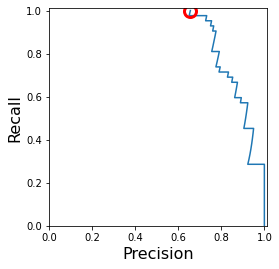

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

#logreg = LogisticRegression().fit(X_train,y_train)
#y_proba_logreg = LogisticRegression().fit(X_train,y_train).predict_proba(X_test)
#r = LogisticRegression().fit(X_train,y_train)
#lr.classes_
precision,recall,thresholds = precision_recall_curve(file_name_dict['10033_08871']['y_train'],file_name_dict['10033_08871']['y_test_proba'][:,1])
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]

plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.axes().set_aspect('equal')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


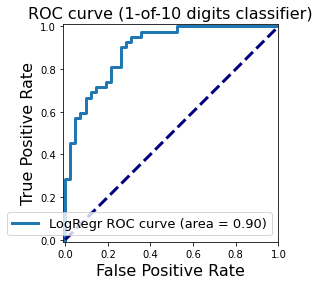

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr_lr, tpr_lr, thresholds = roc_curve(file_name_dict['10033_08871']['y_train'],file_name_dict['10033_08871']['y_test_proba'][:,1])
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

In [ ]:
def run_subject_model_cv(data_path_dict, destination_path, runs_train, runs_list, mask_type, mask_ind, norm_type='none'):
  """
    Function to run cross validation for data. Note: takes 2 hours to run on all subjects.
    Params:
      data_path_dict  : dictionary containing paths to all data stored on AWS
      path : path to save pickle files. NOTE: If run on all subjects, this will take up about 20 GB
      file_name : name of file to prepend to subject id
      runs_train: what runs do we want to train on
      runs_test: what runs do we want to test on
      mask_type: which type of brain mask do we want to apply
      mask_ind: to distinguish between ROI regions of masking(1) and full brain(or full_brain minus ROIs)(0)
      do_psc: do we want to apply Percent Signal Change normalization. Default = True,
      norm: Takes three parameters: none(no normalization will be applied),"SUBJECT"(apply normalization per subject)
            "RUNS"(apply normalization per run separately)
  Returns: cv_dict, a dictionary that holds cv results
  """

  cv_dict = {}
  subject_ids,subj_paths = get_subj_information(data_path_dict)
  mask_labels_indices,binary_labels,label_type = get_labels(data_path_dict)
  mask_data = get_mask_data(data_path_dict,mask_ind)
  mask = make_mask(mask_data[mask_type])
  for idx in range(len(subject_ids)):
    subj_id = subjs_id[idx]
    subj_path = subjs_paths[idx]
    subj_data = access_load_data(subj_path,True) 
    masked_data = mask_data(subj_data,mask,mask_labels_indices)
     
    sub_data = user_data_dict[sub_id]
    sub_labels = user_data_dict[f"{sub_id}_rt_labels"]
    clf = run_single_subject_svm(sub_data,sub_labels,runs_train,runs_test,norm_type,do_cv=True)
    cv_dict[sub_id] = {}
    cv_dict[sub_id]['model'] = clf
  filehandler = open(destination_path,"wb")
  pickle.dump(cv_dict,filehandler)
  filehandler.close() 
  return cv_dict

In [ ]:
cv_dict = {} #initialize the results dictionary
##what runs do you want to normalize on
destination_path = '/content/drive/My Drive/data/dataexploration/cross_validation_results/cv_results.pkl' #where to save data
runs_train=['run_02'] #runs we want to train on
runs_list=[2] #cv results
cv_params = {'C':[1, 5, 10,1000],'kernel':['linear', 'rbf'],'gamma': [.0001, .01, 'auto','scale']}
subject_ids,subj_paths = get_subj_information(data_path_dict)
mask_labels_indices,binary_labels,label_type = get_labels(data_path_dict)
mask_data = get_mask_data(data_path_dict,0)
mask = make_mask(mask_data['mask'])
for idx in range(len(subject_ids)):
  subj_id = subjs_id[idx]
  subj_path = subjs_paths[idx]
  subj_data = access_load_data(subj_path,True) 
  masked_data = mask_data(subj_data,mask,mask_labels_indices)
  scaled_data = scale_data_single_subj(masked_data,runs_train,runs_test,norm='zscore')
  clf = run_single_subject_svm(scaled_data,runs_train,binary_labels,do_cv=True,params=cv_params)
  cv_dict[subj_id] = {}
  cv_dict[subj_id]['model'] = clf
filehandler = open(destination_path,"wb")
pickle.dump(cv_dict,filehandler)
filehandler.close() 

In [ ]:
##what runs do you want to normalize on
destination_path = '/content/drive/My Drive/data/dataexploration/cross_validation_results/cv_results.pkl'
runs_train=['run_02'] #runs we want to train on
runs_test=['run_03','run_04'] #runs we want to test on
runs_list=[2]
mask_type = 'mask'
mask_ind = 0
cv_results = run_subject_model_cv(data_path_dict,destination_path,runs_train,runs_list,mask_type,mask_ind,norm='zscore')